# Final projection exploration notebook

Dataset: https://www.kaggle.com/datasets/crawford/cat-dataset/data, Oct 9 2024, 11:05am

"super small projects"

In [3]:
import os
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image

from sklearn.cluster import KMeans


from C4_helper import DataLoader, get_bbox, grabcut_algorithm, get_ROIs

data_dir = './cats/'
cut_img_file = 'grabCut_np_imgs.npy'

toy_dir = './cats/CAT_00'
toy_cuts = 'grabCut_toy.npy'

# Object detection
Goal for object detection with bboxes
Simplyfying assumption: No other animals than cats, 1 animal at a time


In [2]:
data = DataLoader(data_dir)
#print('Amount of cat img files in source dir:', len(data.train))
if os.path.isfile(cut_img_file):
    img_ROIs = np.load(cut_img_file)
else:
    img_ROIs = get_ROIs(data.imgs)  # currently skips images with no bbox (131/7997)

    if cut_img_file:
        np.save(cut_img_file, img_ROIs)

print('Amount of image-ROIs to work with:', len(img_ROIs)) #1h23h

100%|██████████| 9997/9997 [1:23:10<00:00,  2.00it/s]


Images excluded: 1471
Due to object detection failure: 282
Due to multiple objects found: 1189
Amount of image-ROIs to work with: 8526


In [17]:
def show_example(fname):
    og_img = Image.open(fname).resize((250,250))
    bbox_img, bbox = get_bbox(fname)
    cut_img = grabcut_algorithm(fname, bbox[0])
    figure, axis = plt.subplots(1, 3)
    figure.set_figwidth(7)

    for i, img in enumerate([og_img, bbox_img, cut_img]):
        axis[i].imshow(img, interpolation='nearest')
    plt.show()

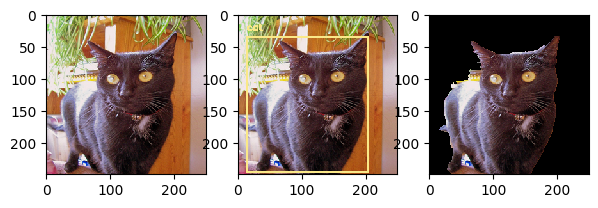

In [20]:
show_example(data.imgs[23])

refine to: face, body, paws, tail?

In [5]:
# lit:
# https://pyimagesearch.com/2018/11/12/yolo-object-detection-with-opencv/, big overview
# Faster R-CNN paper: https://arxiv.org/abs/1506.01497
# faster r-cnn in pytorch: http://pytorch.org/vision/main/models/generated/torchvision.models.detection.fasterrcnn_resnet50_fpn.html#torchvision.models.detection.fasterrcnn_resnet50_fpn


# Unsupervised clustering

In [21]:
# normalise values
# oct 21, 16:32
#https://github.com/beleidy/unsupervised-image-clustering/blob/master/capstone.ipynb
flat_ROIs = list()
for img_arr in img_ROIs:
    flat_ROIs.append(img_arr.flatten())
flat_ROIs = np.array(flat_ROIs, dtype=np.float32)
flat_ROIs /= 255
#flat_ROIs = KMeans.fit_transform(flat_ROIs)
flat_ROIs.shape #8526, 187500

In [34]:
kmeans = KMeans(n_clusters=2, init='k-means++', random_state=0)
Y = kmeans.fit_predict(flat_ROIs)

print(Y) #2mins for n=5, 50sec for n=2

[0 1 0 ... 1 1 1]


In [56]:
clusters = {cluster_id : list() for cluster_id in set(Y)}
for i, cluster_id in enumerate(Y):
    clusters[cluster_id].append(img_ROIs[i])
[('cluster nr: '+ str(id), 'items in cluster: '+ str(len(clusters[id]))) for id in set(Y)]

[('cluster nr: 0', 'items in cluster: 3877'),
 ('cluster nr: 1', 'items in cluster: 4649')]

In [4]:
def vis_cluster(cluster, n_items=21):
    cluster = cluster[:n_items]
    clen = len(cluster)
    figure, axis = plt.subplots(int(clen/3), 3)
    figure.set_figwidth(8)
    figure.set_figheight(15)

    for i, img in enumerate(cluster):
        if i < int(clen/3):
            axis[i][0].imshow(img, interpolation='nearest')
        elif i < int(clen/3*2):
            axis[i-int(clen/3)][1].imshow(img, interpolation='nearest')
        else: 
            axis[i-int(clen/3*2)][2].imshow(img, interpolation='nearest')


    plt.show()

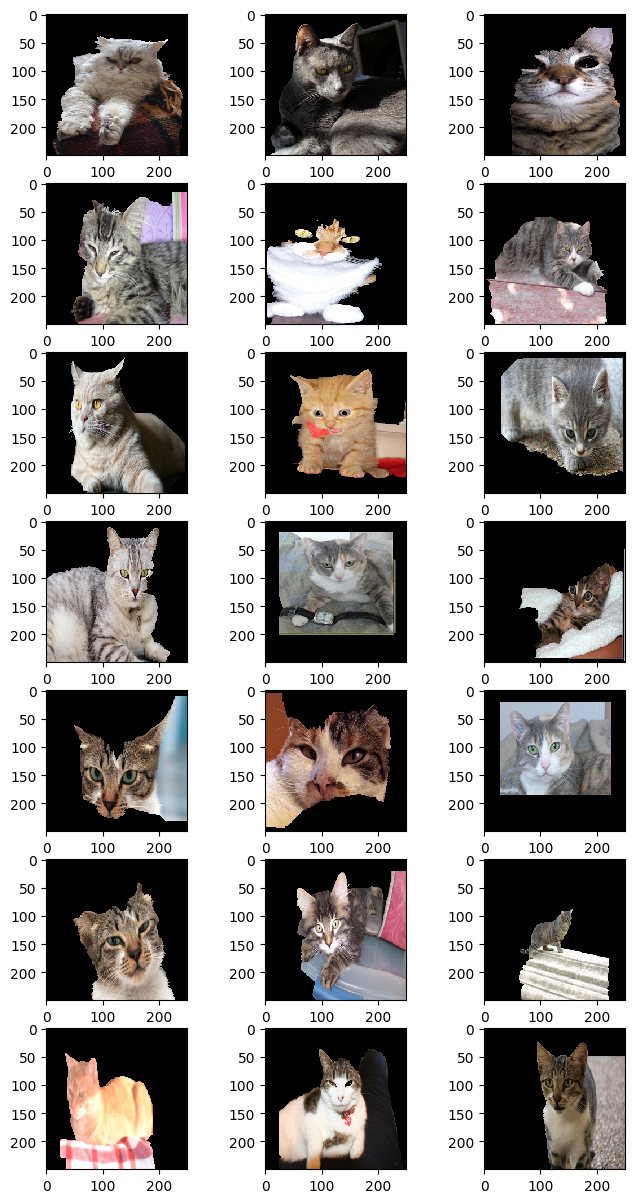

In [66]:
vis_cluster(clusters[0])

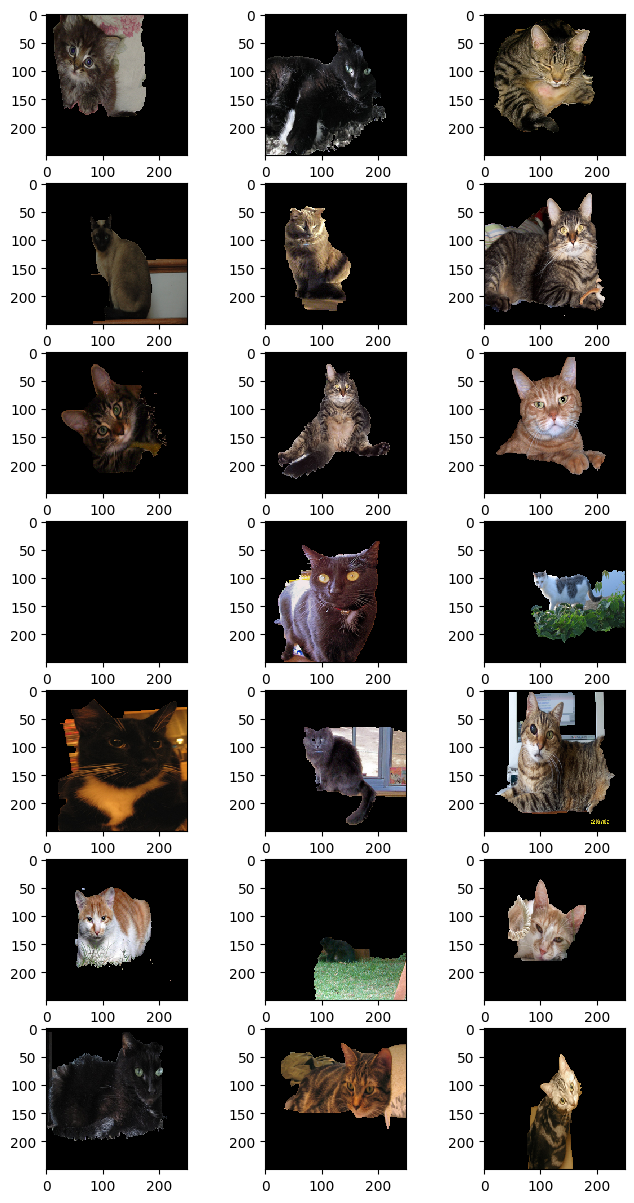

In [67]:
vis_cluster(clusters[1])

## comparison with raw images

In [5]:
img_arrays = [np.array(Image.open(imgfile).resize((250,250))) for imgfile in data.imgs]
flat_imgs = np.array([img_arr.flatten() for img_arr in img_arrays], dtype=np.float32)
# img_arrays /= 255
flat_imgs.shape #1min50

(9997, 187500)

In [7]:
kmeans_comp = KMeans(n_clusters=2, init='k-means++', random_state=0)
Y_comp = kmeans_comp.fit_predict(flat_imgs)

print(Y_comp[:10]) #3m40 n=2 for unnnormalised


[1 0 0 0 1 0 1 1 0 0]


In [11]:
clusters_comp = {cluster_id : list() for cluster_id in set(Y_comp)}
for i, cluster_id in enumerate(Y_comp):
    clusters_comp[cluster_id].append(img_arrays[i])

In [12]:
[print(x) for x in [('cluster nr: '+ str(id), 'items in cluster: '+ str(len(clusters_comp[id]))) for id in set(Y_comp)]]

('cluster nr: 0', 'items in cluster: 4816')
('cluster nr: 1', 'items in cluster: 5181')


[None, None]

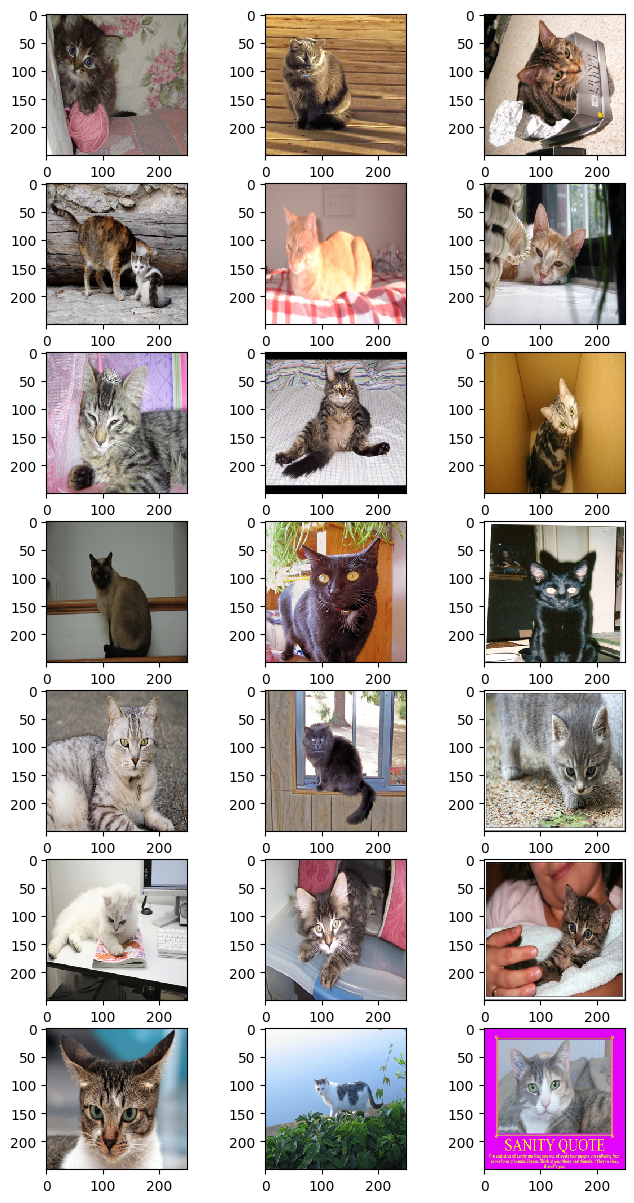

In [13]:
vis_cluster(clusters_comp[0])

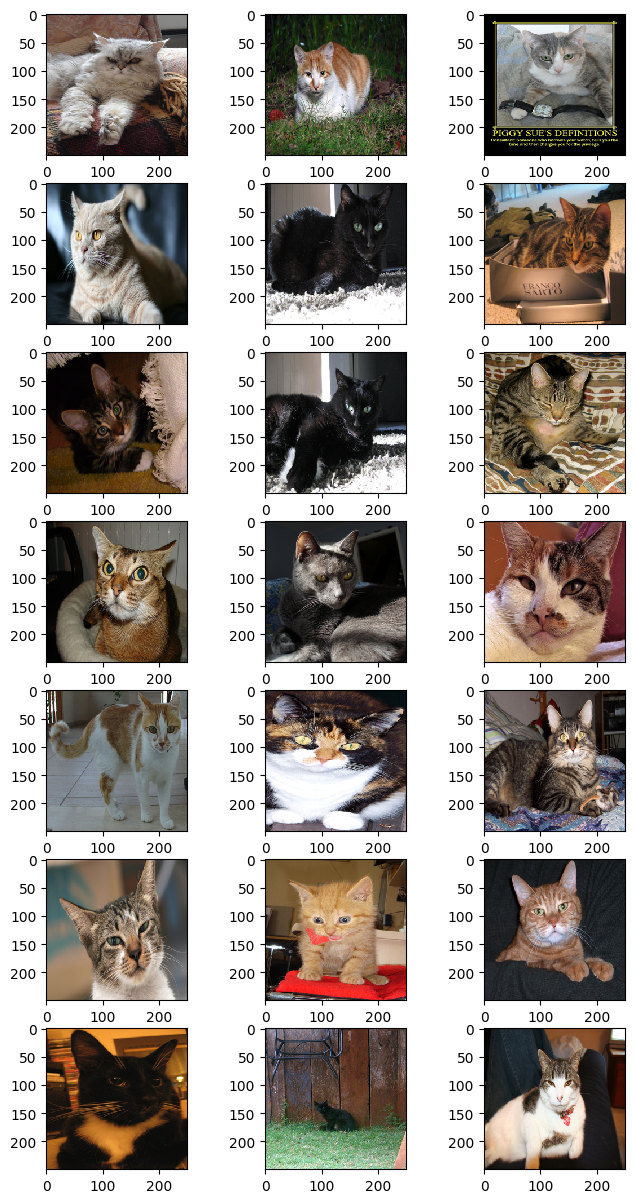

In [14]:
vis_cluster(clusters_comp[1])

In [8]:
# ?? use ggplot in r 
# on clustering https://www.geeksforgeeks.org/clustering-in-machine-learning/

# project https://www.trpkovski.com/2023/10/23/grouping-images-by-colours-exploring-colour-based-image-clustering

In [9]:
# features: max pooling for darkest & lightest areas, also mean colour
# normalise with cnn first to reduce noise, also adjust for lighting
# later adapt if u use different region?

In [10]:
# code example?
# https://github.com/beleidy/unsupervised-image-clustering/blob/master/capstone.ipynb
